# Ergodic Performance Bounds in Fading Channels with Fixed Rayleigh Fading Marginals

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig

This notebook is part of the paper "Copula-Based Multi-User Performance Bounds - Part I: Theory" ([doi:XXX](https://doi.org/XXX)).  
If you use any of this work, please cite the above paper.

In [1]:
import numpy as np
from scipy import integrate
from scipy.special import expi
from scipy import stats
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

from expectation_bounds import lower_sum_rate, upper_sum_rate, indep_sum_rate
from expectation_bounds import lower_mac_rate, upper_mac_rate, indep_mac_rate

# Scenario

$\color{red}{TODO}$
We consider a channel with fading and interference: Alice wants to transmit a message to Bob over a channel with gain $X$. At the same time, another user transmits which causes interference modeled by $Y$.

This gives the following expressions of the signal-to-interference-plus-noise ratio (SINR) and capacity:
$$\text{SINR}=\rho({X}, {Y}) = \frac{{X}}{s + {Y}}$$
$$R(X, Y) = \log_2\left(1 + \rho(X, Y)\right) = \log_2\left(1 + \frac{X}{s + Y}\right)$$

The signal-to-noise ratio (SNR) is given as $\text{SNR}=1/s$.

In the following, we will consider the case of Rayleigh fading. The receive signals $X$ and $Y$ are therefore exponentially distributed, i.e., $X\sim\exp(\lambda_{x})$, $Y\sim\exp(\lambda_{y})$.


# Results

In the following, the upper and lower bound on both the expected SINR and capacity are presented. For comparison, the independent case is also given.
The derivations can be found in $\color{red}{\text{add link to paper}}$.

# Sum Rate

Text about the sum rate.

$$R_{\text{Sum}} = \log_2\left(1 + \rho_{x}X + \rho_{y}Y\right)$$

In [2]:
def calc_sum_rate(snr_db, bound='min', lam_x=1, lam_y=1):
    snr_lin = 10**(snr_db/10.)
    #s = 1./snr_lin
    if bound.startswith('ind'):
        return indep_sum_rate(lam_x=lam_x, lam_y=lam_y, snr_x=snr_lin, snr_y=snr_lin)
    elif bound.startswith('min') or bound.startswith('low'):
        return lower_sum_rate(lam_x=lam_x, lam_y=lam_y, snr_x=snr_lin, snr_y=snr_lin)
    elif bound.startswith('max') or bound.startswith('up'):
        return upper_sum_rate(lam_x=lam_x, lam_y=lam_y, snr_x=snr_lin, snr_y=snr_lin)
    else:
        return NotImplemented

In [3]:
def capacity_plot():
    fig, ax = plt.subplots(num="Ergodic Sum Rate")
    ax.set_xlabel("SNR $\\rho_{x}=\\rho_{y}$ [dB]")
    ax.set_ylabel("Ergodic Sum Rate")
    ax.set_ylim([0, 3])
    plots = {}
    snr_db = np.arange(-5, 6)
    keys = ['min', 'max', 'ind']
    #keys = ['min']
    for _key in keys:
        plots[_key] = ax.plot(snr_db, np.zeros(len(snr_db)), 'o-', label=_key)[0]
    fig.legend()
    
    def update_plot(lam_x=1, lam_y=1):
        for _key, _plot in plots.items():
            _plot.set_ydata(calc_sum_rate(snr_db, _key, lam_x=lam_x, lam_y=lam_y))
        fig.canvas.draw_idle()
    
    interact(update_plot, lam_x=(.1, 3., .1), lam_y=(.25, 5., .25))

<IPython.core.display.Javascript object>


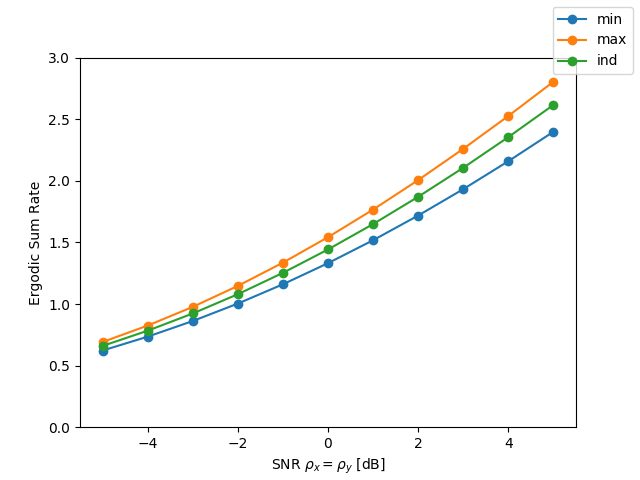

interactive(children=(FloatSlider(value=1.0, description='lam_x', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [4]:
capacity_plot()

# MAC Rate

In [5]:
def calc_mac_rate(snr_db, bound='min', lam_x=1, lam_y=1):
    snr_lin = 10**(snr_db/10.)
    if bound.startswith('ind'):
        return indep_mac_rate(lam_x=lam_x, lam_y=lam_y, snr=snr_lin)
    elif bound.startswith('min') or bound.startswith('low'):
        return lower_mac_rate(lam_x=lam_x, lam_y=lam_y, snr=snr_lin)
    elif bound.startswith('max') or bound.startswith('up'):
        return upper_mac_rate(lam_x=lam_x, lam_y=lam_y, snr=snr_lin)
    else:
        return NotImplemented

In [6]:
def capacity_plot():
    fig, ax = plt.subplots(num="Ergodic MAC Rate")
    ax.set_xlabel("SNR [dB]")
    ax.set_ylabel("Ergodic Rate")
    ax.set_ylim([0, 3])
    plots = {}
    snr_db = np.arange(-5, 6)
    keys = ['min', 'max', 'ind']
    for _key in keys:
        plots[_key] = ax.plot(snr_db, np.zeros(len(snr_db)), 'o-', label=_key)[0]
    fig.legend()
    
    def update_plot(lam_x=1, lam_y=1):
        for _key, _plot in plots.items():
            _plot.set_ydata(calc_mac_rate(snr_db, _key, lam_x=lam_x, lam_y=lam_y))
        fig.canvas.draw_idle()
    
    interact(update_plot, lam_x=(.1, 3., .1), lam_y=(.25, 5., .25))

<IPython.core.display.Javascript object>


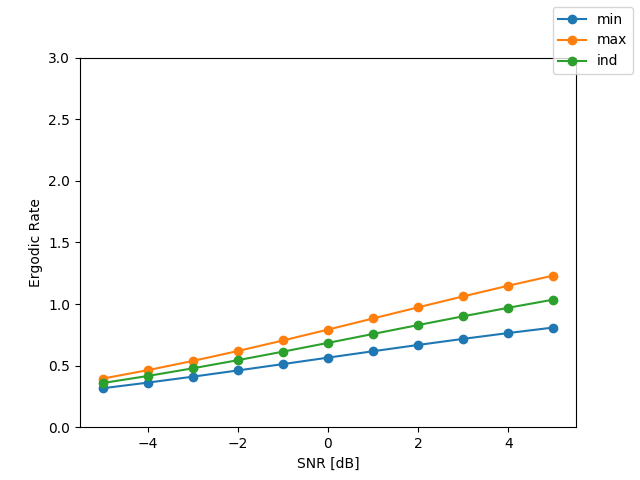

interactive(children=(FloatSlider(value=1.0, description='lam_x', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [7]:
capacity_plot()